# Classification
In this notebook we explore a *multiclass classification* problem -- we want to predict [*Complaint Type*](#target) based on the other features.
<ul>
    <li><a href="#process">Training and testing considerations</a></li>
    <li>Feature <a href="#extraction">extraction</a> and <a href="#selection">selection</a></li>
    <li>Simple <a href="#model">baseline model</a></li>
</ul>

Note: we are aware that *multilabel classification* may appear a better fit here -- we have some categories like *noise residential, noise commertial* and also *noise*.

In [1]:
import os, re
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
# we might need
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score

In [3]:
# local conf
with open('header','r') as source:
    FEATURES = source.read().strip().split(',')
    
YEARS = np.arange(2010, 2020)

In [4]:
# memoization table
lookup = dict()
# get feature value given the index
def get_name(f,i):
    if int(i) == 0:
        return 'Other'
    if not f in lookup:
        try: # check if we have local index (updated categorization)
            index = pd.read_csv('./data/local-{}'.format(FEATURES.index(f)), header = None)[0]
        except FileNotFoundError:
            index = pd.read_csv('./data/index-{}.csv'.format(FEATURES.index(f)))['value']
        lookup[f] = index.tolist()
    return lookup[f][int(i) - 1]

<a name="target"></a>
#### Prediction target

In [5]:
TARGET = 'Complaint Type'

# load target-labels
labels = pd.read_csv('./data/index-{}.csv'.format(FEATURES.index(TARGET))).set_index('value')
labels.head(20).astype(int).style.background_gradient(cmap = 'Oranges')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
value,,,,,,,,,,,
nois residenti,115632,111447,127943,151516,192608,208026,221906,230227,217917,232861,1810083
heat hot water,0,0,0,0,132767,225706,227959,213521,223835,212075,1235863
block drway,49972,52592,50818,57408,79170,100881,119046,136213,137199,137738,921037
illeg park,19901,34204,32037,44156,63243,92679,122479,146240,163396,198360,916695
light,116466,101314,93981,92502,94665,98107,89122,84195,76264,68211,914827
heat,214218,190184,182974,202896,97597,0,0,0,0,0,887869
plumb,115606,117716,91205,89810,67221,60075,57848,58129,61911,41003,760524
paint plaster,93194,100704,77288,78848,75619,69698,60336,57076,59570,34261,706594
water system,70338,61578,57676,53186,55884,71079,73318,65097,76278,63462,647896


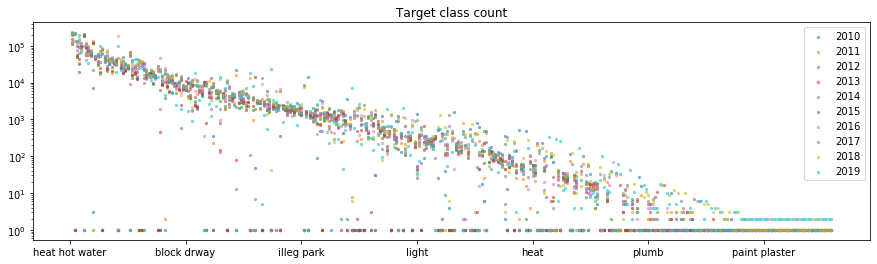

In [6]:
fig, ax = plt.subplots(figsize = (15,4))
x = [i + 1 for i in range(len(labels))]
for y in YEARS:
    ax.scatter(x, labels[str(y)] + 1, s = 5, alpha = .5, label = y)
ax.set_title('Target class count')
ax.set_yscale('log')
ax.set_xticklabels(labels.index.tolist())
plt.legend()
plt.show()

Observation: we have lots of classes with highly imbalanced representation.

In [7]:
# take only "stable" classes: present through all the decade with sufficient support
MIN_SUPPORT = 1000
FILTER = np.where((labels > MIN_SUPPORT).sum(axis = 1) == len(labels.columns))[0]
len(FILTER)

72

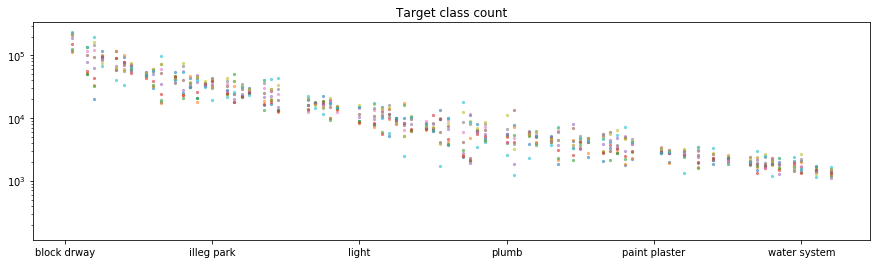

In [8]:
fig, ax = plt.subplots(figsize = (15,4))
x = [i + 1 for i in FILTER]
for y in YEARS:
    ax.scatter(x, labels.iloc[FILTER][str(y)] + 1, s = 5, alpha = .5, label = y)
ax.set_title('Target class count')
ax.set_yscale('log')
ax.set_xticklabels(labels.index[FILTER].tolist())
plt.show()

In [9]:
# classes of interest
classes = [str(i + 1) for i in FILTER]

<a name="process"></a>
#### Trainig and testing
Let's compile some utilities.
We might need a data sample whith balanced class representation.

In [10]:
# balanced train-test split for one vs. the rest scenario
def get_balanced_one(target, value, sample_size, split_ratio = 0.8):
    # compute positive and negative segments for a class value
    yes = np.where(target == value)[0]
    no = np.where(target != value)[0]
    # in case we do not have enough
    sample_size = min(sample_size, len(yes), len(no))
    # compute split index
    cut = int(split_ratio * sample_size)
    # convert to actual indices in a random sample of wanted size
    yes = yes[np.random.choice(len(yes), sample_size).astype(int)]
    no = no[np.random.choice(len(no), sample_size).astype(int)]
    # compile tran-test indices
    train = list(yes[:cut]) + list(no[:cut])
    test = list(yes[cut:]) + list(no[cut:])
    # return in time order
    return sorted(train), sorted(test)

In [11]:
# use all from minority class, for the rest get random sample of the same size
def get_balanced_all(target, split_ratio = 0.8):
    order = target.groupby(target).size().sort_values()
    n, train, test = order.iloc[0], [], []
    cut = int(split_ratio * n)
    for value in order.index:
        I = np.where(target == value)[0]
        I = I[np.random.choice(len(I), n).astype(int)]
        train += list(I[:cut])
        test += list(I[cut:])
    # return in time order
    return sorted(train), sorted(test)    

We might need some visual performance diagnostics.

In [12]:
# visual multilabel confusion-matrix
def confusion_matrix(actual, predicted, classes, cmap = 'BuPu', size = (8,8)):
    d, n = len(classes), len(actual)
    mx = np.empty((n, 2))
    mx[:,0] = predicted # x-axis
    mx[:,1] = actual # y-axis
    mx = pd.DataFrame(mx, columns = ['P','A']).groupby(['P','A'])\
                .size().reset_index().astype(int).values
    # some combination may be missing
    cm = np.zeros((d, d))
    for i in range(mx.shape[0]): # assign
        cm[mx[i,0],mx[i,1]] = mx[i,2]
    cm /= cm.sum() # normalize
    
    fig, ax = plt.subplots(figsize = size)
    ax.imshow(cm, cmap = cmap)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    if len(classes) > 10:
        # do not show labels or annotations
        ax.set_xticks([])
        ax.set_yticks([])
    else: # show labels 
        ax.set_xticks(np.arange(d))
        ax.set_yticks(np.arange(d))
        ax.set_xticklabels(labels.index)
        ax.set_yticklabels(labels.index)
        # show annotations
        norm = cm.max()/2
        for i in range(d):
            for j in range(d):
                text = ax.text(j, i, '{:.2%}'.format(cm[i,j]) if cm[i,j] >= 1e-4 else '',
                               ha = 'center', va = 'center',
                               color = 'w' if cm[i,j] > norm else 'black')
    fig.tight_layout()
    plt.show()

<a name="extraction"></a>
#### Feature extraction

In [13]:
# run single year
YEAR = 2017

In [14]:
data = pd.read_csv('data/{}.csv'.format(YEAR), dtype = str).set_index('Unique Key')
data = data[data[TARGET].isin(classes)]
data.columns

Index(['Agency', 'Complaint Type', 'Descriptor', 'Created Date', 'Closed Date',
       'Address Type', 'Location Type', 'Incident Zip', 'Incident Address',
       'Street Name', 'City', 'Borough', 'Latitude', 'Longitude', 'Time',
       'AmPm', ':local:'],
      dtype='object')

We have a lot of categoric features wich may or may not be useful: for the baseline we leave them out.

In [15]:
base = ['Address Type','Location Type','Created Date','AmPm','City','Borough','Latitude','Longitude']
# keep base features and create <other> category for None
data = data[[TARGET] + base].fillna('0')

We add some features which should be useful ( [according our initial exploration](Exploration.ipynb#temporal) ).

In [16]:
# add temporal categories
def add_temp_cat(data):
    D = data['Created Date'].str.split('-', expand = True).astype(int)
    D.columns = ['Year','Month','Day']
    data['Created Date'] = pd.to_datetime(data['Created Date'], infer_datetime_format = True)
    D['Weekday'] = data['Created Date'].dt.weekday
    return data.join(D).drop('Year', axis = 1)
    
data = add_temp_cat(data)    
data.columns

Index(['Complaint Type', 'Address Type', 'Location Type', 'Created Date',
       'AmPm', 'City', 'Borough', 'Latitude', 'Longitude', 'Month', 'Day',
       'Weekday'],
      dtype='object')

In [17]:
# certain
numeric = ['Latitude','Longitude','AmPm']
categorical = ['Address Type','Location Type','City','Borough']
# consideration
ordinal = ['Month','Day','Weekday']

In [18]:
Y = data[TARGET].values
X = np.hstack((data[numeric].astype(float).values, data[ordinal].astype(int).values))
X.shape

(1764636, 6)

In [19]:
features = numeric + ordinal
onehot = dict()
for f in categorical:
    dummies = pd.get_dummies(data[f], prefix = f, prefix_sep = ': ') 
    onehot[f] = dummies.columns.tolist()
    n, a = X.shape
    X = np.concatenate((X, dummies.values), axis = 1)
    features += ['{}: {}'.format(f, get_name(f, x.split().pop())) for x in onehot[f]]
    n, b = X.shape
    print('{} index: {}:{}'.format(f, a, b))

Address Type index: 6:12
Location Type index: 12:42
City index: 42:143
Borough index: 143:149


Scaling and normalization is always useful:

In [20]:
scaler = StandardScaler()
X[:,:len(numeric)] = scaler.fit_transform(X[:,:len(numeric)])

In [21]:
summary = pd.DataFrame(X).describe().transpose()
summary.index = features

In [22]:
stats = 'mean std min 25% 50% 75% max'.split()

In [23]:
summary.loc[numeric, stats].style.format('{:.2f}').background_gradient(cmap = 'Oranges', axis = 1)

,mean,std,min,25%,50%,75%,max
Latitude,-0.00,1.00,-3.25,0.30,0.31,0.31,0.32
Longitude,0.00,1.00,-0.32,-0.31,-0.31,-0.30,3.25
AmPm,0.00,1.00,-2.28,-0.73,-0.05,0.86,1.70


In [24]:
summary.loc[ordinal, stats].style.format('{:.2f}').background_gradient(cmap = 'Blues', axis = 1)

,mean,std,min,25%,50%,75%,max
Month,6.61,3.28,1.00,4.00,7.00,9.00,12.00
Day,15.76,8.81,1.00,8.00,16.00,23.00,31.00
Weekday,2.89,1.97,0.00,1.00,3.00,5.00,6.00


In [25]:
cat = summary.iloc[len(numeric) + len(ordinal):,1:]
# check variability
cat['std'].quantile([.25, .5])

0.25    0.001844
0.50    0.017015
Name: std, dtype: float64

In [26]:
# show most variable
cat.loc[cat['std'] > 0.1, stats].sort_values('std', ascending = False)\
    .style.format('{:.2f}').background_gradient(cmap = 'Greens', axis = 1)

,mean,std,min,25%,50%,75%,max
Location Type: STREET,0.40,0.49,0.00,0.00,0.00,1.00,1.00
Borough: BROOKLYN,0.32,0.47,0.00,0.00,0.00,1.00,1.00
City: BROOKLYN,0.31,0.46,0.00,0.00,0.00,1.00,1.00
Location Type: Other,0.28,0.45,0.00,0.00,0.00,1.00,1.00
Borough: QUEENS,0.26,0.44,0.00,0.00,0.00,1.00,1.00
Location Type: RESIDENTIAL,0.25,0.43,0.00,0.00,0.00,0.00,1.00
Address Type: ADDRESS,0.78,0.42,0.00,1.00,1.00,1.00,1.00
Borough: MANHATTAN,0.19,0.40,0.00,0.00,0.00,0.00,1.00
City: NEW YORK,0.18,0.39,0.00,0.00,0.00,0.00,1.00
Borough: BRONX,0.17,0.37,0.00,0.00,0.00,0.00,1.00


<a name="selection"></a>
#### Feature selection

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf = {}
importance = np.empty((len(features), len(classes)))
accuracy = []

# check class-separability in One-vs-Rest setting
for i,value in enumerate(classes):
    # get balanced data (minority class size)
    train, test = get_balanced_one(Y, value, MIN_SUPPORT, split_ratio = 0.8)
    y = (Y == value).astype(int)
    model = RandomForestClassifier(n_estimators = 100,
                                   max_depth = 2,
                                   oob_score = True,
                                   random_state = None)
    model.fit(X[train], y[train])    
    accuracy.append((model.predict(X[test]) == y[test]).sum()/len(test))
    importance[:,i] = model.feature_importances_
    print('{:>30}   training oob-score: {:.2f}  test accuracy: {:.2f}'\
                        .format(labels.index[i], model.oob_score_, accuracy[-1]))
    clf[value] = model

                nois residenti   training oob-score: 0.93  test accuracy: 0.94
                heat hot water   training oob-score: 0.85  test accuracy: 0.85
                   block drway   training oob-score: 0.84  test accuracy: 0.84
                    illeg park   training oob-score: 0.93  test accuracy: 0.94
                         light   training oob-score: 0.83  test accuracy: 0.83
                          heat   training oob-score: 0.89  test accuracy: 0.89
                         plumb   training oob-score: 0.90  test accuracy: 0.92
                 paint plaster   training oob-score: 0.88  test accuracy: 0.87
                  water system   training oob-score: 0.87  test accuracy: 0.86
                     construct   training oob-score: 0.83  test accuracy: 0.85
               construct plumb   training oob-score: 0.95  test accuracy: 0.96
                          nois   training oob-score: 0.82  test accuracy: 0.82
                 nois sidewalk   training oob-score:

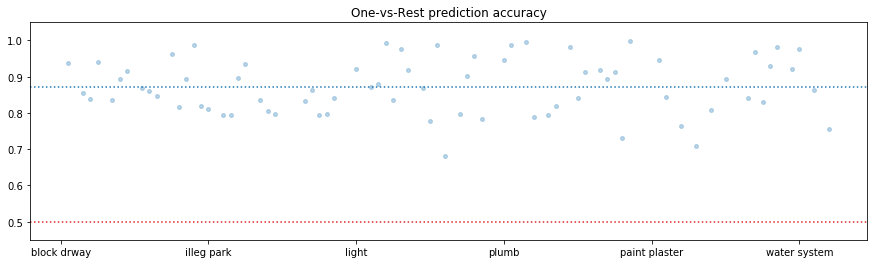

In [29]:
# see how much better than random guess
fig, ax = plt.subplots(figsize = (15,4))
x = [i + 1 for i in FILTER]
ax.scatter(x, accuracy, s = 15, alpha = .3)
ax.axhline(y = np.mean(accuracy), color = 'C0', linestyle = ':')
ax.axhline(y = .5, color = 'C3', linestyle = ':')
ax.set_title('One-vs-Rest prediction accuracy')
ax.set_xticklabels(labels.index[FILTER].tolist())
ax.set_ylim([.45, 1.05])
plt.show()

In [30]:
# sort by importance
order = importance.sum(axis = 1).argsort()[::-1]
importance = importance[order]

# top 25 by average
pd.DataFrame(np.mean(importance[:25,:], axis = 1), columns = ['Avg. Impotrance'],
             index = np.array(features)[order[:25]])\
    .style.format('{:,.2%}').background_gradient(cmap = 'Oranges')

,Avg. Impotrance
Location Type: STREET,11.55%
Location Type: Other,11.07%
Location Type: RESIDENTIAL,9.82%
Longitude,6.77%
Address Type: ADDRESS,6.73%
Latitude,6.73%
Address Type: INTERSECTION,4.62%
AmPm,4.06%
Address Type: Other,3.19%
City: Other,2.73%


<a name="model"></a>
#### Baseline model
For our base model we go for the two layers neural network with *ReLu* activation -- we clearly need some non-linearity here, and a dense with *softmax* for the output (we might be looking at the multi-label scenario).

In [31]:
# one-hot encode the target
Y = pd.get_dummies(data[TARGET], prefix = TARGET, prefix_sep = ': ').values

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization

Using TensorFlow backend.


In [33]:
model = Sequential()

model.add(Dense(X.shape[1], input_dim = X.shape[1]))
model.add(Dropout(0.4)) # prevent overfitting
model.add(BatchNormalization()) # faster conversion
model.add(Activation('relu'))

model.add(Dense(X.shape[1]))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(len(classes)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 149)               22350     
_________________________________________________________________
dropout_1 (Dropout)          (None, 149)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 149)               596       
_________________________________________________________________
activation_1 (Activation)    (None, 149)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 149)               22350     
_________________________________________________________________
dropout_2 (Dropout)          (None, 149)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 149)              

In [34]:
# set optimization strategy
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [35]:
# get data
train, test = get_balanced_all(data[TARGET])

In [36]:
# train model
res = model.fit(X[train,:], Y[train,:], epochs = 100, batch_size = 512,
                validation_data = [X[test,:], Y[test,:]], verbose = False)

In [37]:
# check test accuracy
prediction = np.argmax(model.predict(X[test,:]), axis = 1)
actual = np.argmax(Y[test,:], axis = 1)
print('Test accuracy: {:.2%}'.format((prediction == actual).sum()/len(test)))

Test accuracy: 32.18%


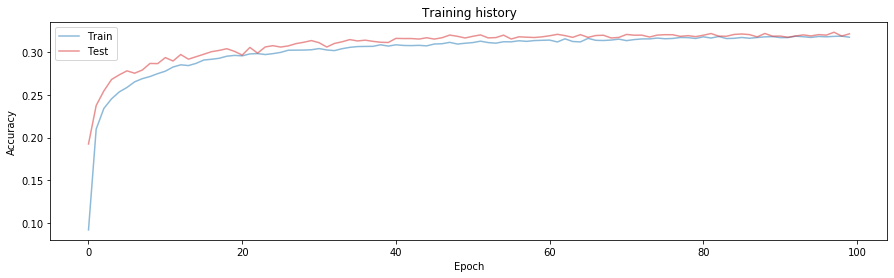

In [38]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(res.history['accuracy'], alpha = .5, label = 'Train')
ax.plot(res.history['val_accuracy'], alpha = .5, color = 'C3', label = 'Test')
ax.set_title('Training history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
# bootstrap the above
for _ in range(10):
    train, test = get_balanced_all(data[TARGET])
    res = model.fit(X[train,:], Y[train,:], epochs = 10, batch_size = 512,
                    validation_data = [X[test,:], Y[test,:]], verbose = False)
    prediction = np.argmax(model.predict(X[test,:]), axis = 1)
    actual = np.argmax(Y[test,:], axis = 1)
    print('Test accuracy: {:.2%}'.format((prediction == actual).sum()/len(test)))

Test accuracy: 32.27%
Test accuracy: 32.34%
Test accuracy: 32.41%
Test accuracy: 31.76%
Test accuracy: 32.06%
Test accuracy: 32.23%
Test accuracy: 31.79%
Test accuracy: 32.06%
Test accuracy: 31.81%
Test accuracy: 31.73%


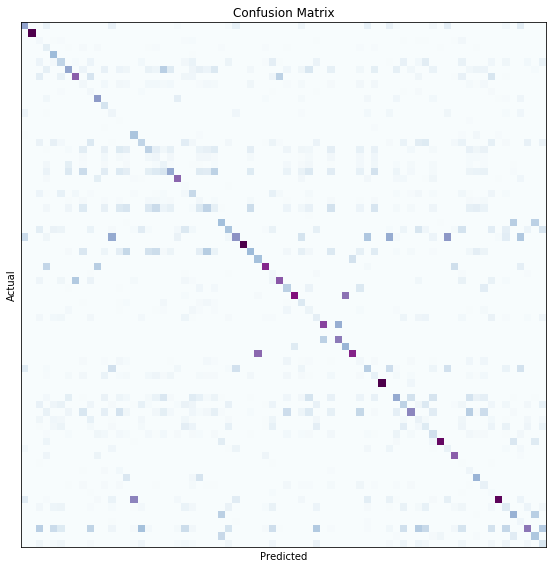

In [40]:
# make visual
confusion_matrix(actual, prediction, classes)

Observation: the outcome is the same for all years. (30% is a decent result here: with multi-label concerns.)

([The other consideration is to use *kNN*](Localization.ipynb).)